In [1]:
import tensorflow as tf
print(tf.__version__)

C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\tensorflow\python\f

1.14.0


*The CWSM formula*
---
 A **State** in a Reinforcement Learning environment is the set of all observable/non observable parameters that an environment throws to an agent in order to take a necessary action. Road and trees for a self driving car, position on points and hurdles for a super mario game,etc are states. 

The CWSM problem gives us a state with the following parameters:
1. Current water level
2. Current water inflow

An **action** is a move/atep taken by an agent for attaining reward in an environment. Up/Down in super mario game; break, accelerate and steer in Self driving cars,etc are actions.
The CWSM problem gives us one action:
1. Expected water outflow




In [2]:
import pandas as pd
import numpy as np
dianna=pd.read_csv('D:\Semester 4\Soft Computing\Chennai Water Supply Manager\\dianna.csv',parse_dates={'date' : ['Date']},na_values=-1)
dianna.info()
dianna.dropna(inplace=True)
dianna=dianna.reset_index()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5844 entries, 0 to 5843
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              5844 non-null   datetime64[ns]
 1   nth day in year   5844 non-null   int64         
 2   Storage (mcft)    5830 non-null   float64       
 3   Inflow (cusecs)   5830 non-null   float64       
 4   Rainfall (mm)     5830 non-null   float64       
 5   Outflow (cusecs)  5816 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 274.1 KB


With an action for time t, we should be able to predict state for time t+1, ie, after jumping on a hurdle, environment should move leftward in a super mario game. Hence the state-action formula is:

*level (t+1)=level(t)+((inflow(t)-outflow(t))* 86400)/(10^6)*
the next *state(t+1)* is *(level(t+1),inflow(t+1))* where *inflow(t+1)* is obtained from the **Dianna Database**

In [3]:
raw=dianna.drop(columns=['index','date','nth day in year'])

### The CWSM environment

The following are the features of our environment:
* State : `(storage,inflow)`
* Action: `(outflow)`

* State space: `([0, 3645] , [0, infinity])`
* Action space: `([0, infinity])`


#### 1. `__init__` function
1. Initialise `self.action_space` with `space.Box` Action constraints
2. Initialise `self.state_space` with `space.Box` State constraints
3. Initialise `self.count` value:- the total number of days passed in current episode 
4. Initialise `self.DEMAND_THRESHOLD` value with 175 cusecs. 
5. Initialise `self.state` with `dianna.iloc[0,0]`
6. Initialise `self.action` with `0`
7. Initialise `self.reward` with `0`


#### 2. `step` function

1. Get `self.action`
2. For given `self.state` and `self.action`, use CWSM formula to get `self.next_state`
3. Grant `self.reward`if Esakki supplies outflow which less than `self.DEMAND_THRESHOLD`, or if the `self.next_state[0]` is greater than `self.MAX_CAPACITY`. 


#### 1. `reset` function
1. Initialise `self.action_space` with `space.Box` Action constraints
2. Initialise `self.state_space` with `space.Box` State constraints
3. Initialise `self.count` value to `0`:- the total number of days passed in current episode 
4. Initialise `self.DEMAND_THRESHOLD` value with 175 cusecs. 
5. Initialise `self.state` with `dianna.iloc[0,0]`
6. Initialise `self.action` with `0`
7. Initialise `self.reward` with `0`


<Figure size 432x288 with 0 Axes>

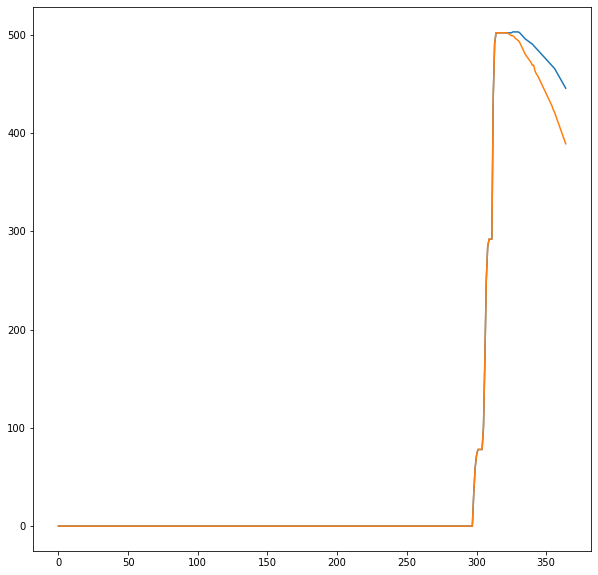

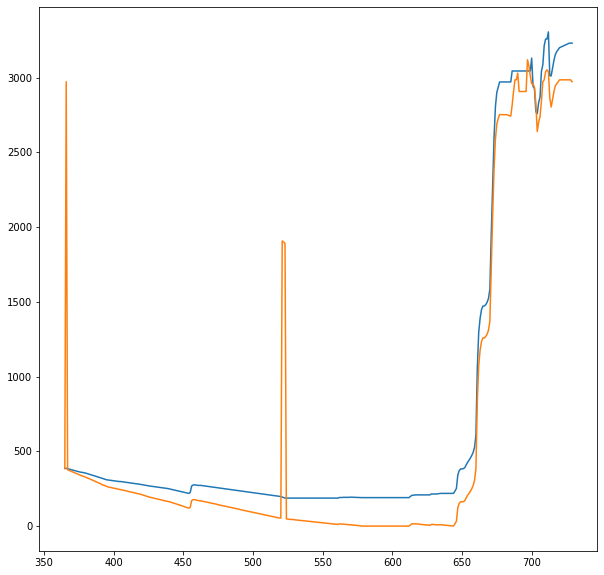

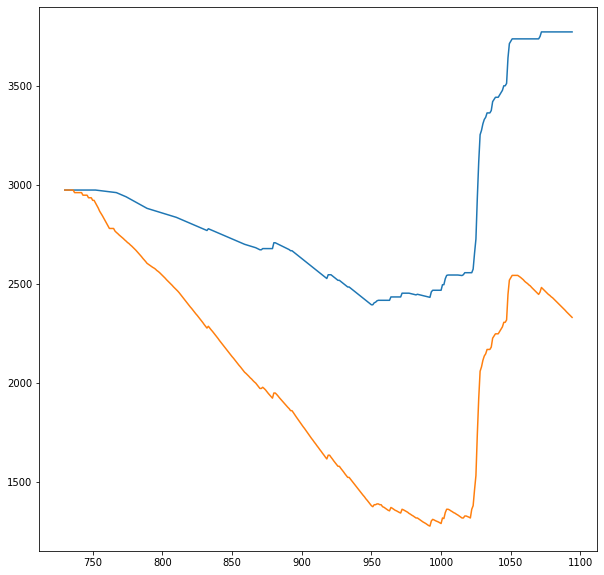

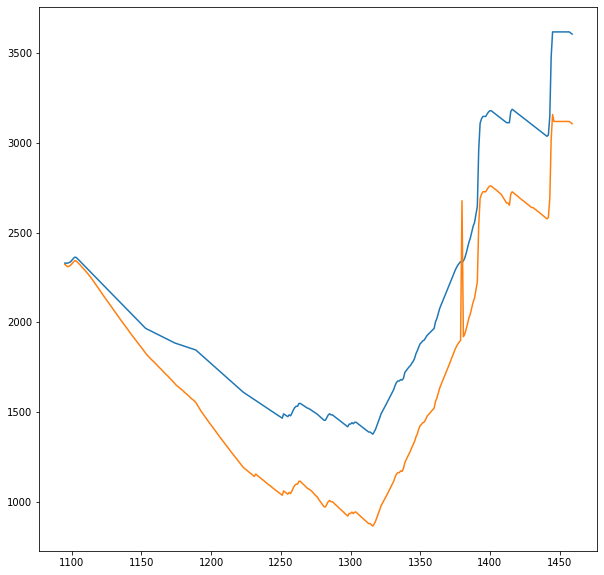

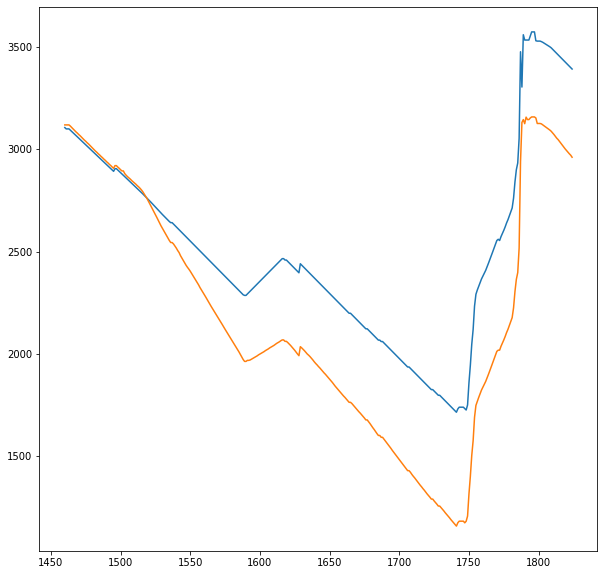

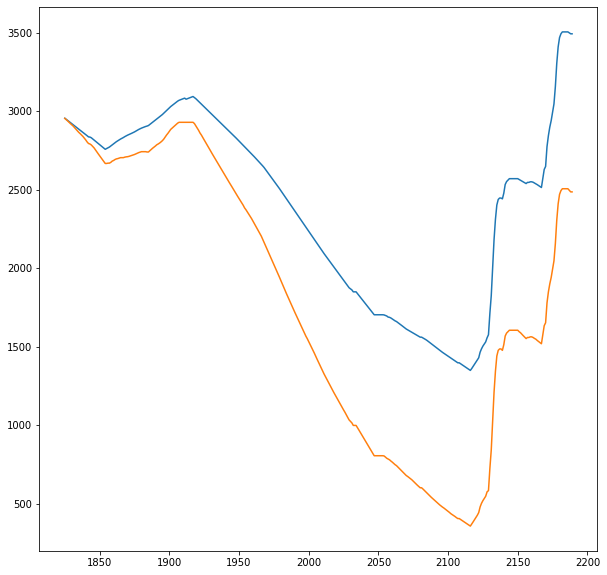

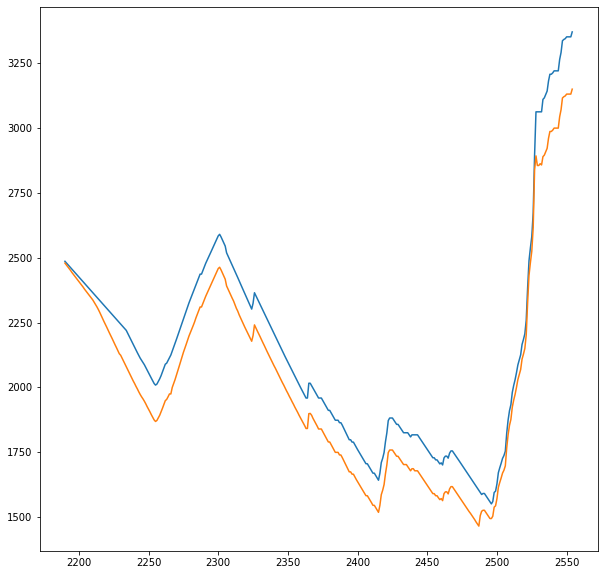

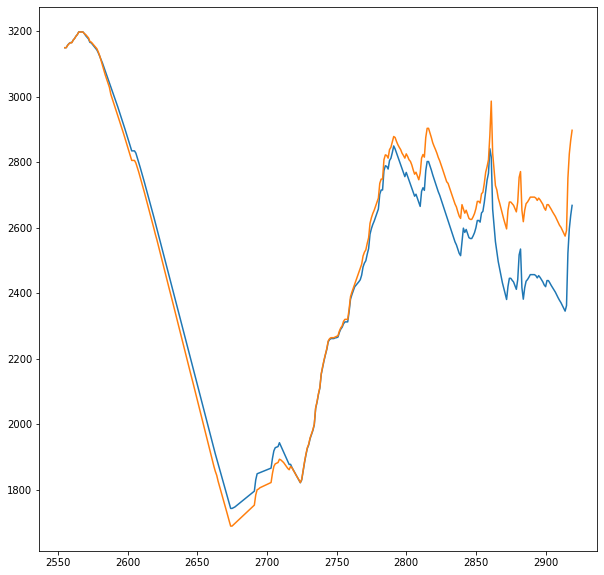

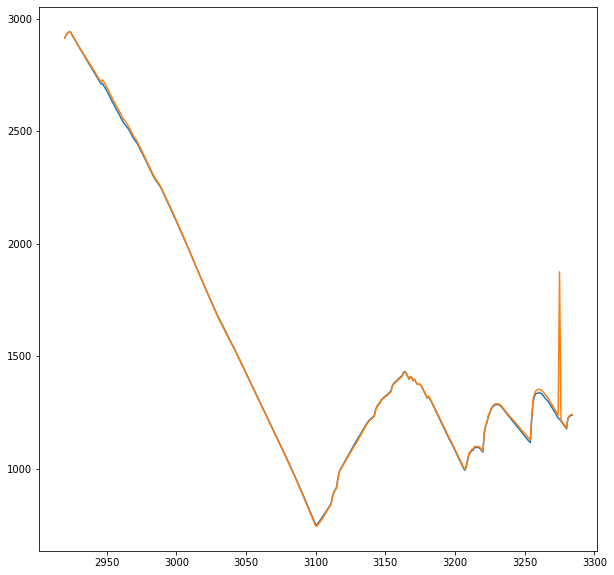

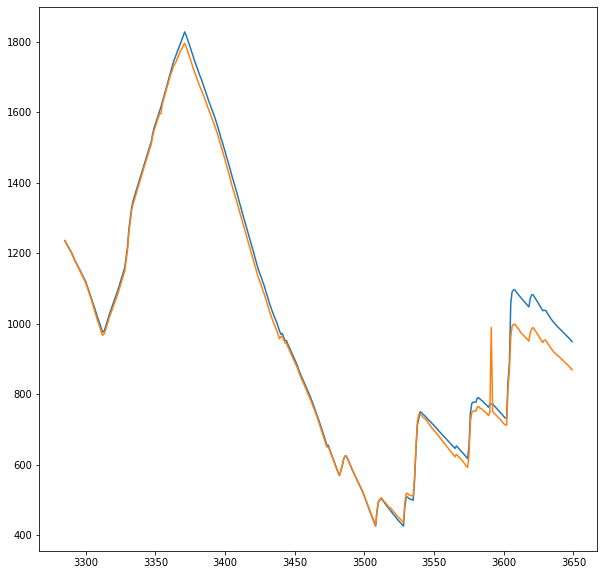

In [23]:
import gym
import matplotlib.pyplot as plt
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
lookback=5

class bkcm(gym.Env):
        metadata = {
            'render.modes': ['human']
        }


        def step(self, a):
            self.action=a
            outflow_factor=0.0864
            inflow_factor=0.0864
            EVAPORATION=0#-raw.iloc[self.count+lookback,2]
            if(self.count%365<175 and self.count%365>20):
                EVAPORATION=0
            #if(raw.iloc[self.count+lookback,2]==0):
                #EVAPORATION=np.random.random(1)*2+2

            res=self.state[4][0]-EVAPORATION+(raw.iloc[lookback+self.count,1]* inflow_factor)-(a* outflow_factor)
            if(res<0):
                res=0
            nextt=np.array(self.state[1:]).tolist()
            nextt.append([res,raw.iloc[lookback+self.count,1],raw.iloc[lookback+self.count,2],a])
            self.state=np.array(nextt)

            if(self.action<self.DEMAND_THRESHOLD):
                self.bad_day+=1
                self.reward=-1
            elif(res>3000):
                self.bad_day+=1
                self.reward=-1
            else:
                self.good_day+=1
                self.reward=0

            self.count+=1

            return self.state, self.reward, self.count>=len(raw)-lookback, {}


        def __init__(self, seed=0):
            self.DEMAND_THRESHOLD=120
            self.MAX_CAPACITY=3000
            self.action = 0.
            self.count = seed
            self.good_day = 0
            self.bad_day = 0
            self.reward=0


            lookback=5
            self.next_state=np.zeros((lookback,raw.shape[-1]))

            sequence=np.zeros((lookback,raw.shape[-1]))
            for j in range(0,lookback):
                    sequence[j]=raw.loc[seed+j,:]
            self.state = sequence

            a=[]
            for i in range(lookback):
                a.append([0., 0.,0., 0.])
            self.low=np.array(a, dtype=np.float32)

            a=[]
            for i in range(lookback):
                a.append([4000., 100000.,1000., 100000.])
            self.high=np.array(a, dtype=np.float32)
            self.action_space = spaces.Box(
                low=0,
                high=100000, shape=(1,),
                dtype=np.uint8
            )
            self.observation_space = spaces.Box(
                low=self.low,
                high=self.high,
                dtype=np.float32
            )


        def reset(self,seed=0):
            self.DEMAND_THRESHOLD=120
            self.MAX_CAPACITY=3000
            self.action = 0.
            self.count = seed
            self.good_day = 0
            self.bad_day = 0
            self.reward=0
            self.next_state=np.zeros((lookback,raw.shape[-1]))
            sequence=np.zeros((lookback,raw.shape[-1]))
            for j in range(0,lookback):
                    sequence[j]=raw.loc[seed+j,:]
            self.state = sequence
            return self.state


        def render(self, mode='human'):
            ;

plt.clf()
import matplotlib.pyplot as plt
for ij in range(0,10):
    
    i=ij*365
    j=i
    a=[]
    env=Chembarambaakam(i)
    state=env.reset(i)
    done=False
    while(not done and i!=j+365):
            #print(i)
            state,reward,done,_=env.step(raw.iloc[lookback+i,3])
            #print(state[4][0],done)
            a.append(state[4][0])
            score+=reward
            i+=1
    plt.figure(figsize=(10,10))
    plt.plot(range(j,i),a)
    plt.plot(range(j,i),raw.iloc[j+lookback:i+lookback,0])
    plt.show()

In [6]:
raw.iloc[i,3]

93.0

# DhanVan3 Model


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



pristine=pd.read_csv('D:\Semester 4\Soft Computing\Chennai Water Supply Manager\\reverse_df.xlsx - Chembarambaakam.csv',parse_dates={'date' : ['Date']},na_values=-1)


pristine=pristine.dropna()


pristine.reset_index(drop=True, inplace=True)
pristine['date']=pd.to_datetime(pristine['date'], format='%d/%m/%y').dt.strftime('%d/%m/%y')


originals=pristine
pristine.head(10)


,date,nth day in year,Storage (mcft),Inflow (cusecs),Rainfall (mm),Outflow (cusecs)
0,01/01/04,0,0.0,0.0,0.0,0.0
1,01/02/04,1,0.0,0.0,0.0,0.0
2,01/03/04,2,0.0,0.0,0.0,0.0
3,01/04/04,3,0.0,0.0,0.0,0.0
4,01/05/04,4,0.0,0.0,0.0,0.0
5,01/06/04,5,0.0,0.0,0.0,0.0
6,01/07/04,6,0.0,0.0,0.0,0.0
7,01/08/04,7,0.0,0.0,0.0,0.0
8,01/09/04,8,0.0,0.0,0.0,0.0
9,01/10/04,9,0.0,0.0,0.0,0.0


In [32]:
raw=pristine
raw=raw.drop(columns=['date','nth day in year'])
'''
cols=['Storage (mcft)', 'Inflow (cusecs)', 'Rainfall (mm)']
for i in cols:
    maxx=max(raw[i])
    minn=min(raw[i])
    raw[i]-=minn
    raw[i]/=(maxx-minn)
raw.describe()'''

"\ncols=['Storage (mcft)', 'Inflow (cusecs)', 'Rainfall (mm)']\nfor i in cols:\n    maxx=max(raw[i])\n    minn=min(raw[i])\n    raw[i]-=minn\n    raw[i]/=(maxx-minn)\nraw.describe()"

In [33]:
#FEATURE EXTRACTION: Prepare sequence



'''
 day n outflow
    
    
    
 5 days dependant   '''
lookback=5
sequence=np.zeros(((len(raw)-lookback),lookback,raw.shape[-1]))
target=np.zeros(len(raw)-lookback)

for i in range(lookback, len(raw)):
    for j in range(0,lookback):
        sequence[i-lookback][j]=raw.loc[i+j-lookback,:]
    target[i-lookback]=raw['Outflow (cusecs)'][i]

In [34]:
def train_test_split(sequence,target,boundary=4380):
    if(boundary<1):
        x_train=sequence[:int(len(sequence)*boundary)]
        x_test=sequence[int(len(sequence)*boundary):]
        y_train=target[:int(len(target)*boundary)]
        y_test=target[int(len(target)*boundary):]
    else:
        x_train=sequence[:boundary]
        x_test=sequence[boundary:]
        y_train=target[:boundary]
        y_test=target[boundary:]
    
    return x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test=train_test_split(sequence,target)
print(x_train.shape,
    x_test.shape,
    y_train.shape,
    y_test.shape)

(4380, 5, 4) (703, 5, 4) (4380,) (703,)


In [35]:
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import layers
DhanVan3=models.Sequential()
DhanVan3.add(layers.LSTM(32,
                        dropout=0.1,
                        recurrent_dropout=0.5,
                        #return_sequences=True,
                        input_shape=(x_train.shape[1], x_train.shape[2])))

'''model.add(layers.LSTM(100, 
                        dropout=0.1,
                        recurrent_dropout=0.5))
                        '''
DhanVan3.add(layers.Dense(1))
DhanVan3.compile(loss='mae', optimizer=optimizers.RMSprop())

DhanVan3.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4736      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = DhanVan3.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=64, 
                    validation_data=(x_test, y_test))

Train on 4380 samples, validate on 703 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/200
4380/4380 [==============================] - 3s 772us/sample - loss: 128.4055 - val_loss: 99.9360
Epoch 2/200
4380/4380 [==============================] - 1s 123us/sample - loss: 127.5383 - val_loss: 99.0617
Epoch 3/200
4380/4380 [==============================] - 1s 126us/sample - loss: 126.9686 - val_loss: 98.3676
Epoch 4/200
4380/4380 [==============================] - 1s 121us/sample - loss: 126.4061 - val_loss: 97.3223
Epoch 5/200
4380/4380 [==============================] - 1s 117us/sample - loss: 125.4324 - val_loss: 96.1702
Epoch 6/200
4380/4380 [==============================] - 1s 122us/sample - loss: 124.5779 - val_loss: 95.0475
Epoch 7/200
4380/4380 [==============================] - 1s 117us/sample - loss: 123.6795 - val_loss: 93.6588
Epoch 8/200
4380/4380 [==============================] - 1s 128us/sample - loss: 122.5711

Epoch 145/200
4380/4380 [==============================] - 1s 125us/sample - loss: 62.0902 - val_loss: 19.4081
Epoch 146/200
4380/4380 [==============================] - 1s 125us/sample - loss: 62.2924 - val_loss: 16.3148
Epoch 147/200
4380/4380 [==============================] - 1s 126us/sample - loss: 62.2966 - val_loss: 17.2810
Epoch 148/200
4380/4380 [==============================] - 1s 127us/sample - loss: 62.4895 - val_loss: 13.8520
Epoch 149/200
4380/4380 [==============================] - 1s 122us/sample - loss: 63.0203 - val_loss: 20.3470
Epoch 150/200
4380/4380 [==============================] - 1s 130us/sample - loss: 63.4684 - val_loss: 16.9562
Epoch 151/200
4380/4380 [==============================] - 1s 137us/sample - loss: 63.7641 - val_loss: 22.1418
Epoch 152/200
4380/4380 [==============================] - 1s 134us/sample - loss: 63.6674 - val_loss: 22.7780
Epoch 153/200
4380/4380 [==============================] - 1s 127us/sample - loss: 63.2754 - val_loss: 20.3438
E

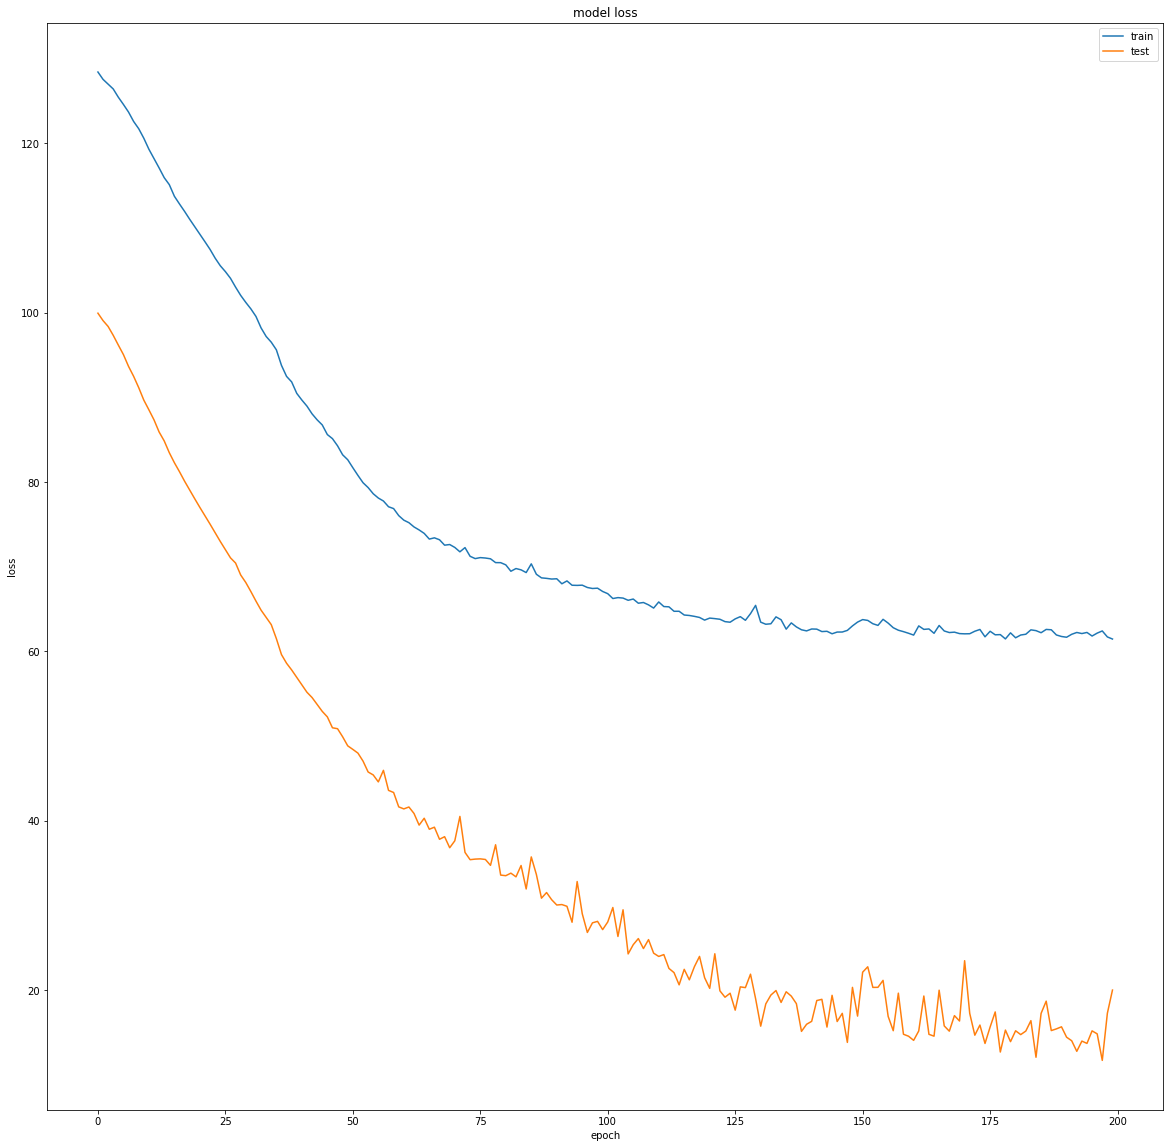

In [37]:
plt.figure(figsize=(20,20))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


# DhanVan3 VS Chennai Metro

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5816 entries, 0 to 5843
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              5816 non-null   datetime64[ns]
 1   nth day in year   5816 non-null   int64         
 2   Storage (mcft)    5816 non-null   float64       
 3   Inflow (cusecs)   5816 non-null   float64       
 4   Rainfall (mm)     5816 non-null   float64       
 5   Outflow (cusecs)  5816 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 318.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5816 entries, 0 to 5815
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Storage (mcft)    5816 non-null   float64
 1   Inflow (cusecs)   5816 non-null   float64
 2   Rainfall (mm)     5816 non-null   float64
 3   Outflow (cusecs)  5816 non-null   float64
dty

<Figure size 432x288 with 0 Axes>

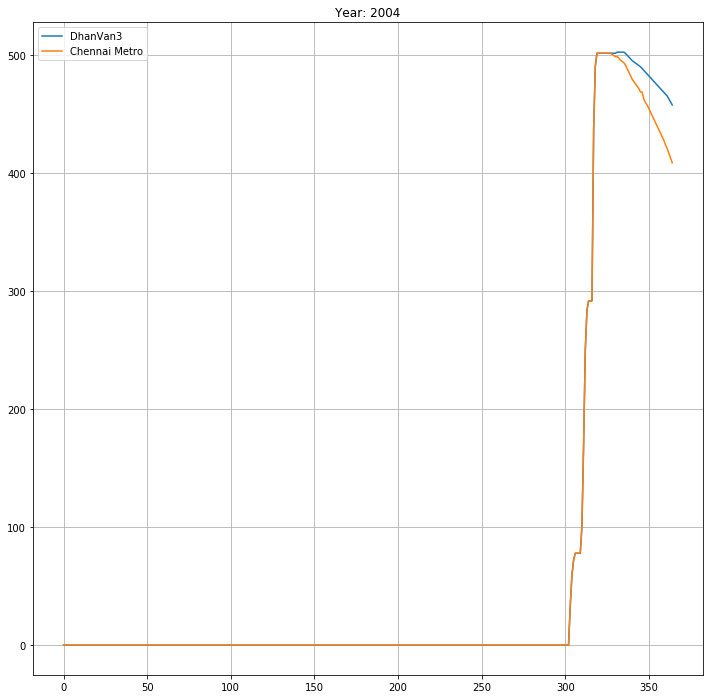


Year  2005
Progress: -------------------------------------------------------------------------------------------

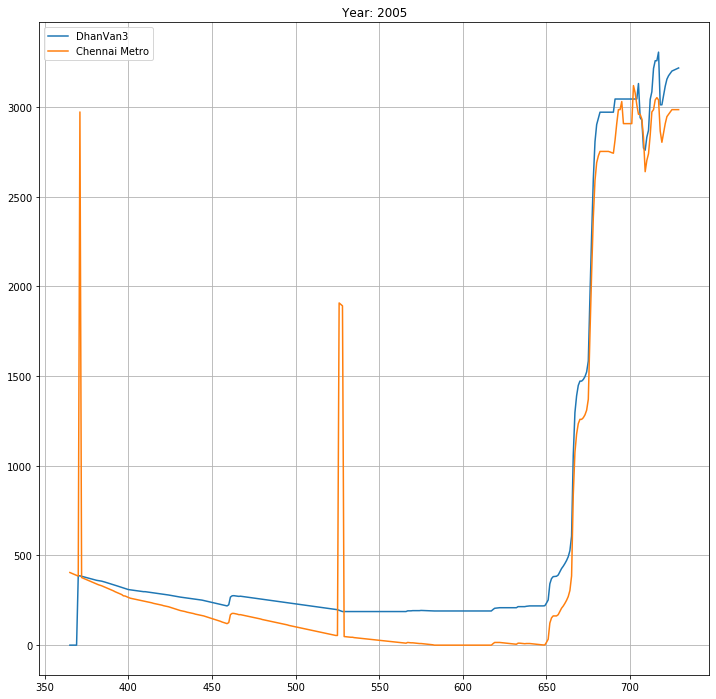


Year  2006
Progress: -------------------------------------------------------------------------------------------

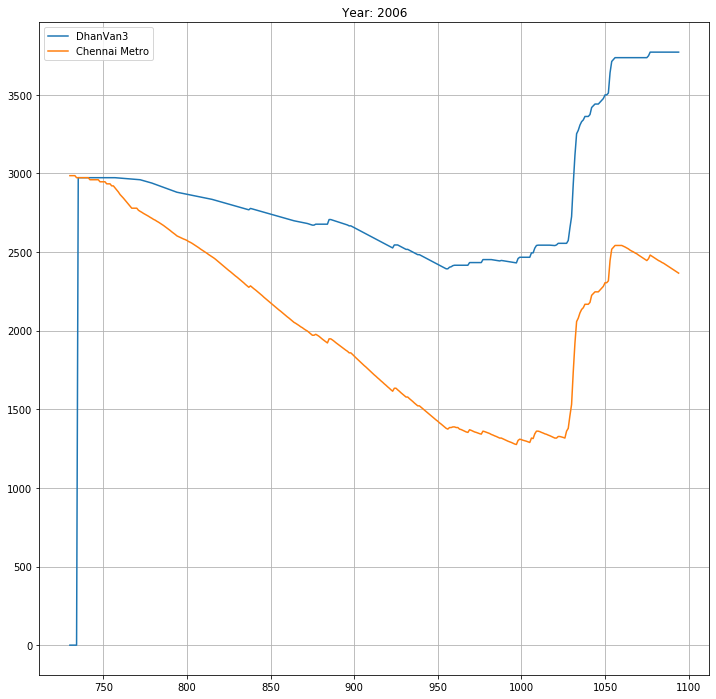


Year  2007
Progress: -------------------------------------------------------------------------------------------

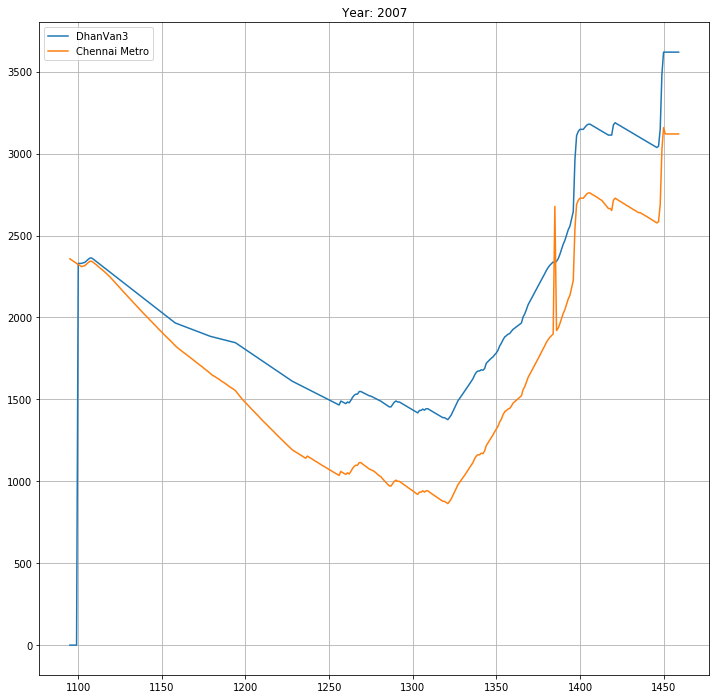


Year  2008
Progress: -------------------------------------------------------------------------------------------

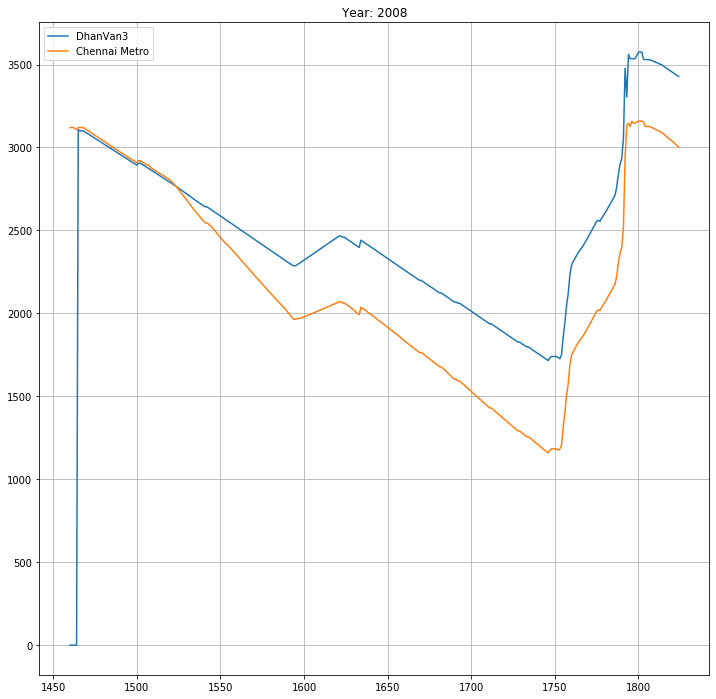


Year  2009
Progress: -------------------------------------------------------------------------------------------

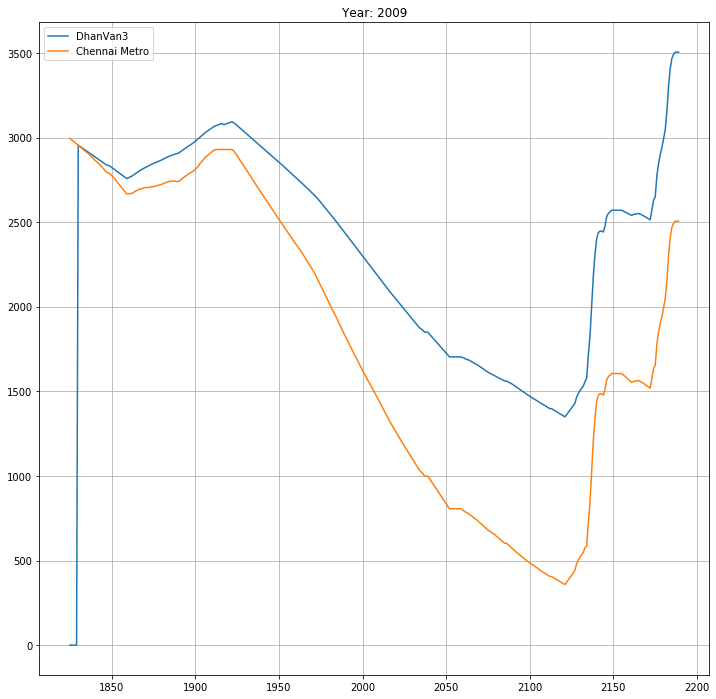


Year  2010
Progress: -------------------------------------------------------------------------------------------

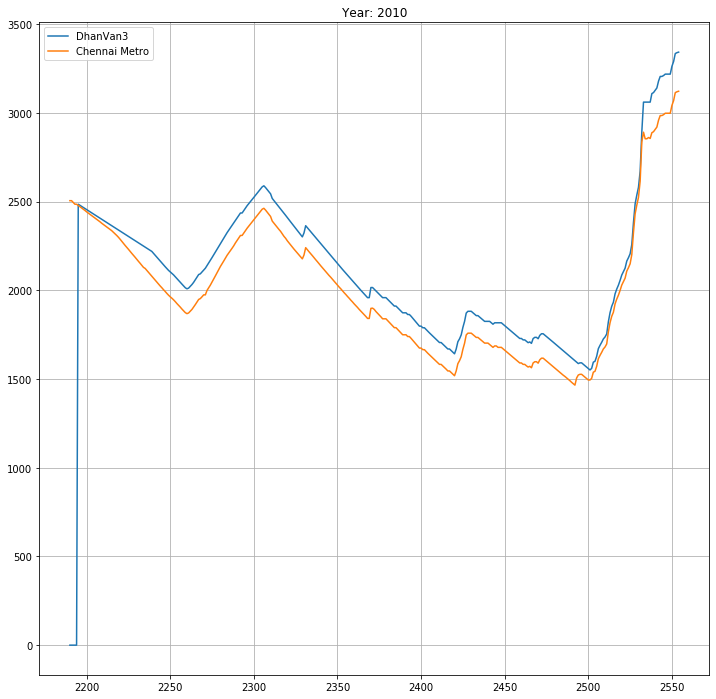


Year  2011
Progress: -------------------------------------------------------------------------------------------

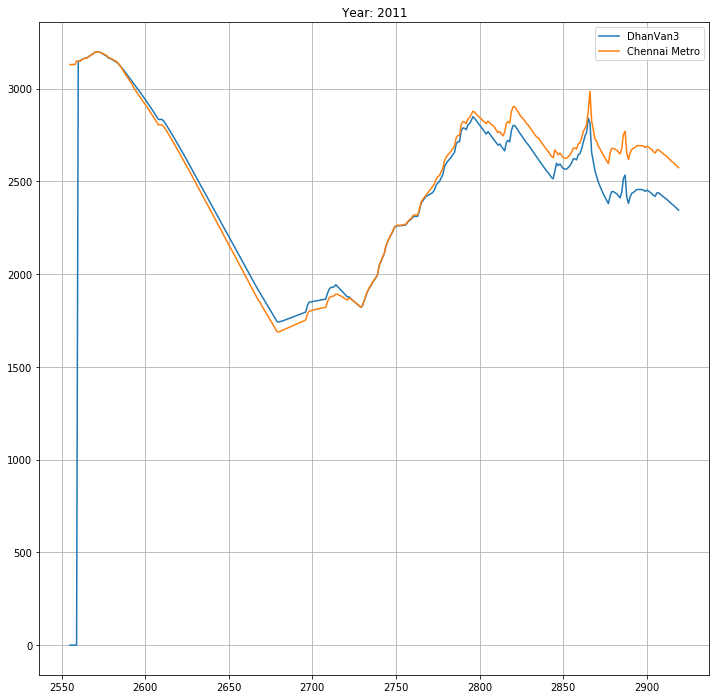


Year  2012
Progress: -------------------------------------------------------------------------------------------

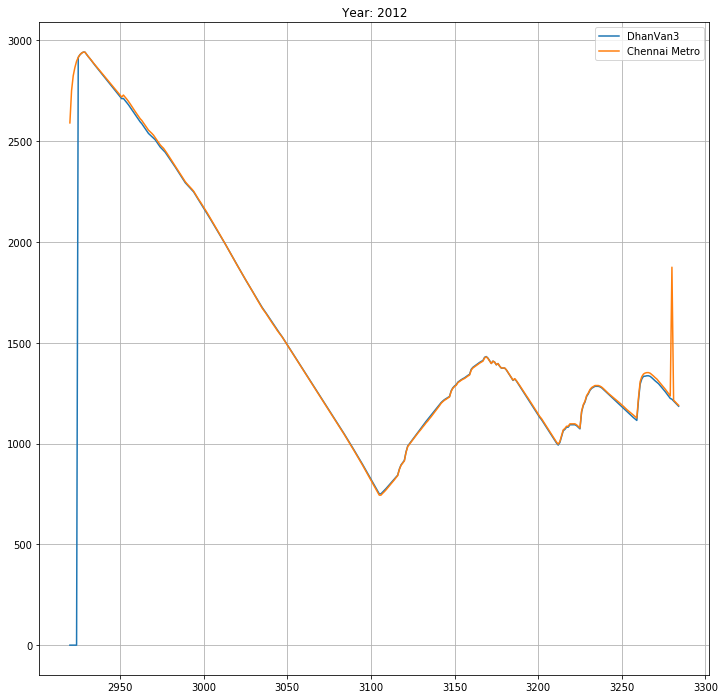


Year  2013
Progress: -------------------------------------------------------------------------------------------

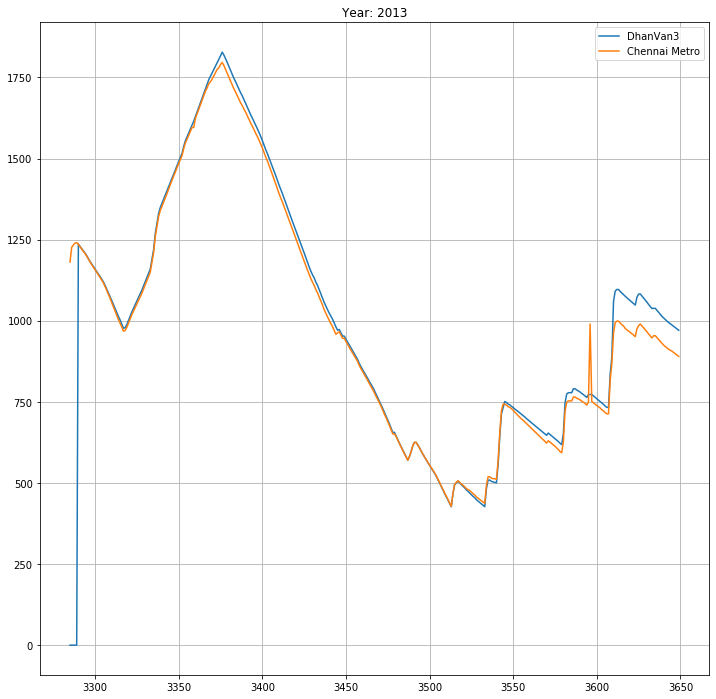


Year  2014
Progress: -------------------------------------------------------------------------------------------

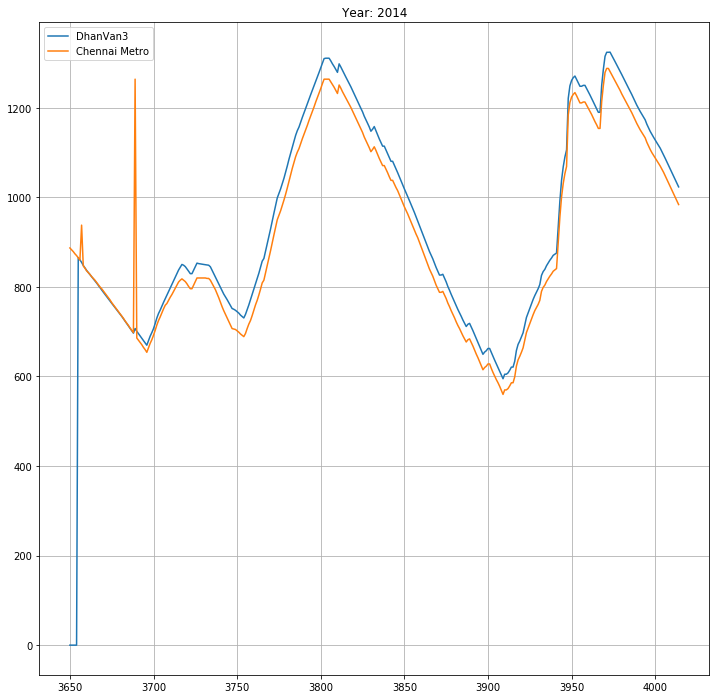


Year  2015
Progress: -------------------------------------------------------------------------------------------

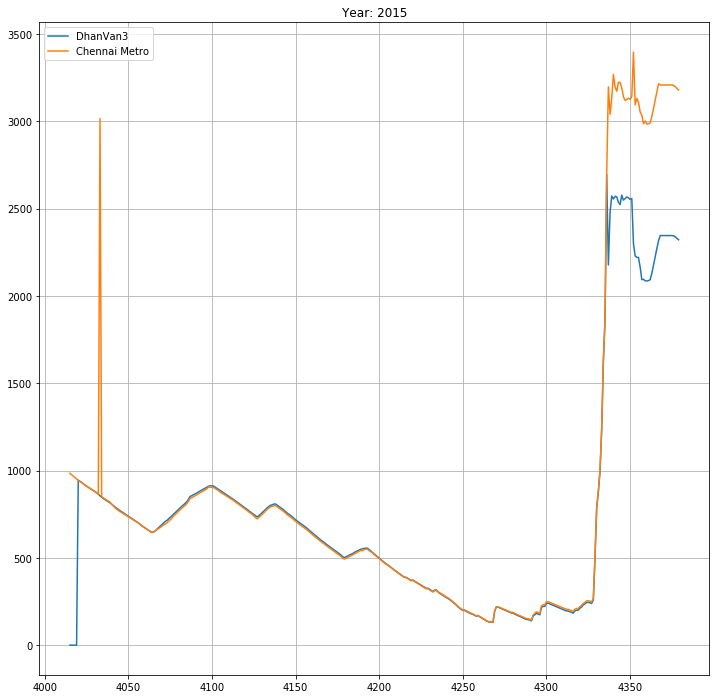


Year  2016
Progress: -------------------------------------------------------------------------------------------

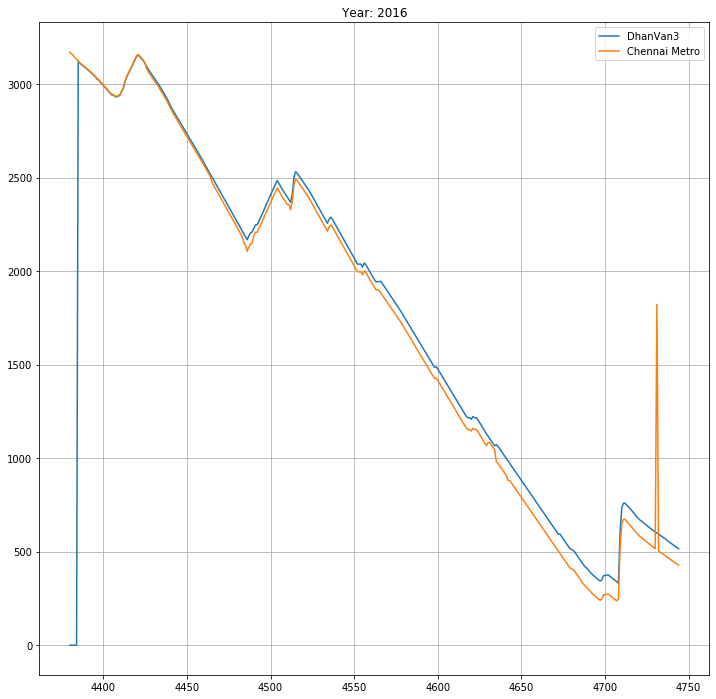


Year  2017
Progress: -------------------------------------------------------------------------------------------

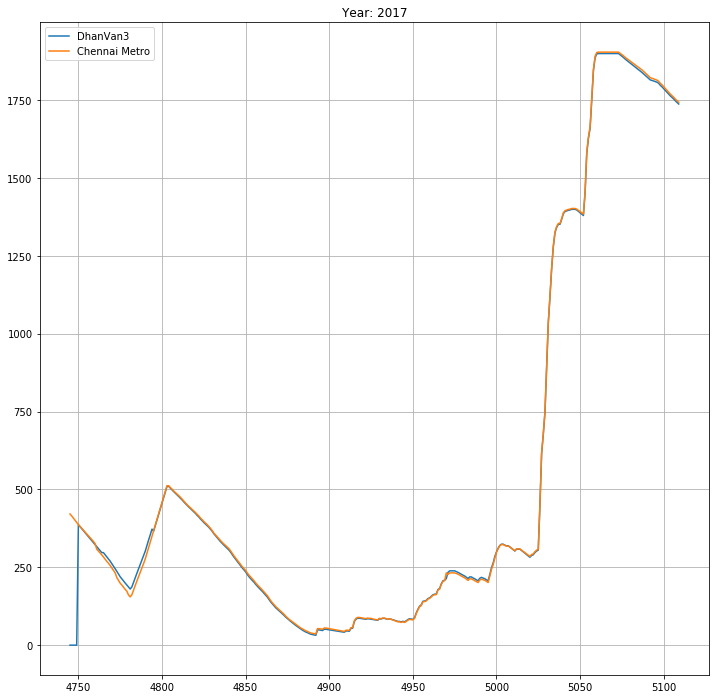


Year  2018
Progress: -------------------------------------------------------------------------------------------

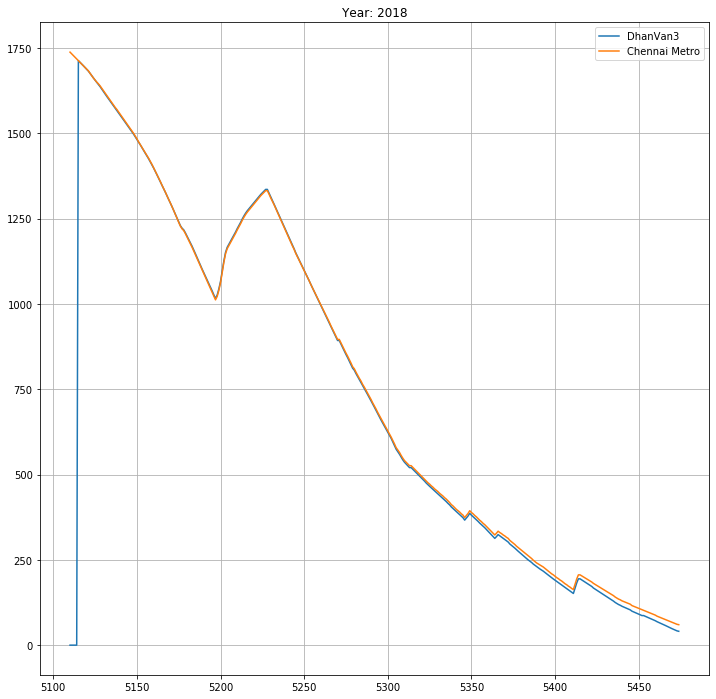


Year  2019
Progress: ------------------------------------------------------------------------------------

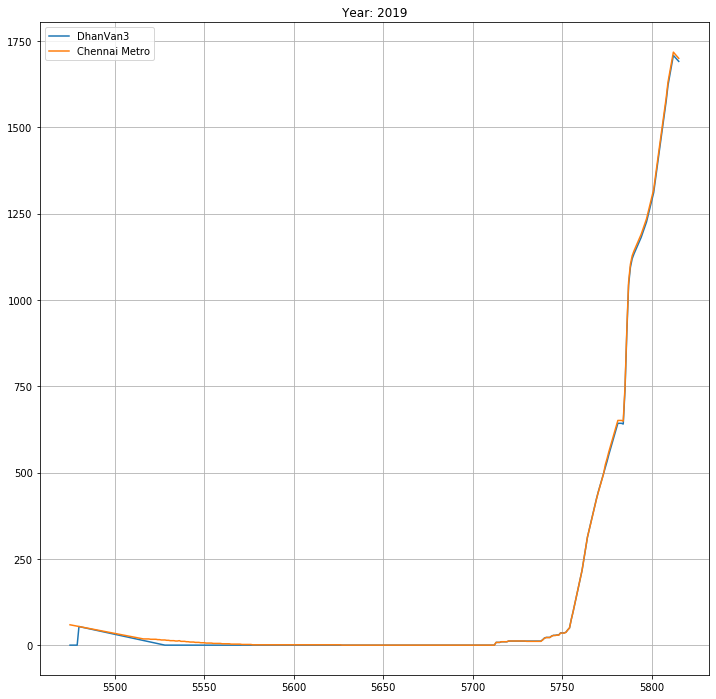

In [26]:

dianna=pd.read_csv('D:\Semester 4\Soft Computing\Chennai Water Supply Manager\\dianna.csv',parse_dates={'date' : ['Date']},na_values=-1)

dianna.dropna(inplace=True)
dianna.info()
dianna=dianna.reset_index()
raw=dianna.drop(columns=['index','date','nth day in year'])
raw.info()
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
plt.clf()
import matplotlib.pyplot as plt

for ij in range (0,16):

    seed=365*ij

    env=Chembarambaakam(seed)
    
    env2=Chembarambaakam(seed)
    state2=env2.reset(seed)
    done=False
    done2=False
    
    i=lookback+seed
    a=[]
    b=[]
    for _ in range(lookback+seed):
        a.append(0.0)
        b.append(0.0)
    score=0
    score2=0
    
    print('\nYear ',2004+ij)
    print('Progress:',end=' ')
    while(not done and not done2):
        #state,reward,done,_=env.step(raw.iloc[i,3])
        #a.append(state[4][0])
        
        state2,reward2,done2,_=env2.step(DhanVan3.predict(np.array([state2]))[0][0])
        b.append(state2[4][0])
        
        if(i%4==0):
            print('-',end='')
        #score2+=reward2
        i+=1
        if(i>=len(raw)):
            break
    
    
    start=seed
    end=start+365
    if(start+365>len(raw)):
        end=len(raw)
    plt.figure(figsize=(12,12))
    plt.plot(range(start,end),b[start:end])
    #plt.plot(range(start,end),a[start:end],linestyle='dashed')
    plt.plot(range(start,end),raw.iloc[start:end,0])
    plt.legend(['DhanVan3','Chennai Metro'])
    
    plt.title('Year: '+str(2004+ij))
    plt.grid()

    plt.show()


'56'

# The ESAKKI-ESHWARI system

    The double E system is an implementation of the Actor-Critic algorithm: a policy-value algorithm in Deep Reinforcement Learning

In [39]:
"""
solving pendulum using actor-critic model
"""

import gym
import numpy as np 
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers.merge import Add, Multiply
from keras.optimizers import Adam
import keras.backend as K

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import random
from collections import deque

# determines how to assign values to each state, i.e. takes the state
# and action (two-input model) and determines the corresponding value
class ActorCritic:
	def __init__(self, env, sess):
		self.env  = env
		self.sess = sess

		self.learning_rate = 0.01
		self.epsilon = 1.0
		self.epsilon_decay = .995
		self.gamma = .95
		self.tau   = .125

		# ===================================================================== #
		#                               Actor Model                             #
		# Chain rule: find the gradient of chaging the actor network params in  #
		# getting closest to the final value network predictions, i.e. de/dA    #
		# Calculate de/dA as = de/dC * dC/dA, where e is error, C critic, A act #
		# ===================================================================== #

		self.memory = deque(maxlen=2000)
		self.actor_state_input, self.actor_model = self.create_actor_model()
		_, self.target_actor_model = self.create_actor_model()

		self.actor_critic_grad = tf.compat.v1.placeholder(tf.float32, 
			[None, self.env.action_space.shape[0]]) # where we will feed de/dC (from critic)
		
		actor_model_weights = self.actor_model.trainable_weights
		self.actor_grads = tf.gradients(self.actor_model.output, 
			actor_model_weights, -self.actor_critic_grad) # dC/dA (from actor)
		grads = zip(self.actor_grads, actor_model_weights)
		self.optimize = tf.compat.v1.train.AdamOptimizer(self.learning_rate).apply_gradients(grads)

		# ===================================================================== #
		#                              Critic Model                             #
		# ===================================================================== #		

		self.critic_state_input, self.critic_action_input, \
			self.critic_model = self.create_critic_model()
		_, _, self.target_critic_model = self.create_critic_model()

		self.critic_grads = tf.gradients(self.critic_model.output, 
			self.critic_action_input) # where we calcaulte de/dC for feeding above
		
		# Initialize for later gradient calculations
		self.sess.run(tf.compat.v1.initialize_all_variables())

	# ========================================================================= #
	#                              Model Definitions                            #
	# ========================================================================= #

	def create_actor_model(self):
		
        state_input = Input(shape=env3.observation_space.shape)
        lstm = LSTM(32,dropout=0.1,recurrent_dropout=0.5)(state_input)
        output= Dense(1)(lstm)
        esakki = Model(input=state_input, output=out)
        esakki.compile(loss='mae', optimizer=optimizers.RMSprop())
		return state_input, esakki

	def create_critic_model(self):
		state_input = Input(shape=self.env.observation_space.shape)
		state_h1 = Dense(24, activation='relu')(state_input)
		state_h2 = Dense(48)(state_h1)
		
		action_input = Input(shape=self.env.action_space.shape)
		action_h1    = Dense(48)(action_input)
		
		merged    = Add()([state_h2, action_h1])
		merged_h1 = Dense(24, activation='relu')(merged)
		output = Dense(1, activation='relu')(merged_h1)
		model  = Model(input=[state_input,action_input], output=output)
		
		adam  = Adam(lr=0.001)
		model.compile(loss="mse", optimizer=adam)
		return state_input, action_input, model

	# ========================================================================= #
	#                               Model Training                              #
	# ========================================================================= #

	def remember(self, cur_state, action, reward, new_state, done):
		self.memory.append([cur_state, action, reward, new_state, done])

	def _train_actor(self, samples):
		for sample in samples:
			cur_state, action, reward, new_state, _ = sample
			predicted_action = self.actor_model.predict(cur_state)
			grads = self.sess.run(self.critic_grads, feed_dict={
				self.critic_state_input:  cur_state,
				self.critic_action_input: predicted_action
			})[0]

			self.sess.run(self.optimize, feed_dict={
				self.actor_state_input: cur_state,
				self.actor_critic_grad: grads
			})
            
	def _train_critic(self, samples):
		for sample in samples:
			cur_state, action, reward, new_state, done = sample
			if not done:
				target_action = self.target_actor_model.predict(new_state)
				future_reward = self.target_critic_model.predict(
					[new_state, target_action])[0][0]
				reward += self.gamma * future_reward
			self.critic_model.fit([cur_state, action], reward, verbose=0)
		
	def train(self):
		batch_size = 32
		if len(self.memory) < batch_size:
			return

		rewards = []
		samples = random.sample(self.memory, batch_size)
		self._train_critic(samples)
		self._train_actor(samples)

	# ========================================================================= #
	#                         Target Model Updating                             #
	# ========================================================================= #

	def _update_actor_target(self):
		actor_model_weights  = self.actor_model.get_weights()
		actor_target_weights = self.target_critic_model.get_weights()
		
		for i in range(len(actor_target_weights)):
			actor_target_weights[i] = actor_model_weights[i]
		self.target_critic_model.set_weights(actor_target_weights)

	def _update_critic_target(self):
		critic_model_weights  = self.critic_model.get_weights()
		critic_target_weights = self.critic_target_model.get_weights()
		
		for i in range(len(critic_target_weights)):
			critic_target_weights[i] = critic_model_weights[i]
		self.critic_target_model.set_weights(critic_target_weights)		

	def update_target(self):
		self._update_actor_target()
		self._update_critic_target()

	# ========================================================================= #
	#                              Model Predictions                            #
	# ========================================================================= #

	def act(self, cur_state):
		self.epsilon *= self.epsilon_decay
		if np.random.random() < self.epsilon:
			return self.env.action_space.sample()
		return self.actor_model.predict(cur_state)

def main():
	sess = tf.compat.v1.Session()
	tf.compat.v1.keras.backend.set_session(sess)
	env = Chembarambaakam()
	actor_critic = ActorCritic(env, sess)

	num_trials = 10000
	trial_len  = 500

	cur_state = env.reset()
	action = env.action_space.sample()
	while True:
		env.render()
		cur_state = cur_state.reshape((1, env.observation_space.shape[0]))
		action = actor_critic.act(cur_state)
		action = action.reshape((1, env.action_space.shape[0]))

		new_state, reward, done, _ = env.step(action)
		new_state = new_state.reshape((1, env.observation_space.shape[0]))

		actor_critic.remember(cur_state, action, reward, new_state, done)
		actor_critic.train()

		cur_state = new_state

if __name__ == "__main__":
	main()

C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\ipykernel_launcher.py:76: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


ValueError: Shapes must be equal rank, but are 2 and 3 for 'gradients_1/dense_14/Relu_grad/ReluGrad' (op: 'ReluGrad') with input shapes: [?,1], [?,5,1].

In [9]:
import tensorflow as tf
#tf.compat.v1.enable_eager_execution()
y=DhanVan3(np.array(sequence[0:1]))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [17]:
y.numpy()[0][0]

0.08665228

In [15]:
DhanVan3.predict(np.array(sequence[0:1]))

array([[0.08665228]], dtype=float32)

In [18]:
model=DhanVan3
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4736      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [29]:
from keras import layers
env3=Chembarambaakam()
state_input = layers.Input(shape=env3.observation_space.shape)

In [24]:
state_input

<tf.Tensor 'input_1:0' shape=(None, 5, 4) dtype=float32>

In [35]:
from keras.models import Sequential, Model

In [30]:
state_input = Input(shape=env3.observation_space.shape)
h1 = Dense(24, activation='relu')(state_input)
h2 = Dense(48, activation='relu')(h1)

In [36]:
model = Model(state_input, h2)

In [37]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 5, 4)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 5, 24)             120       
_________________________________________________________________
dense_10 (Dense)             (None, 5, 48)             1200      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [40]:
DhanVan3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4736      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [41]:
y=DhanVan3()(state_input)

TypeError: __call__() missing 1 required positional argument: 'inputs'

In [13]:
env3=Chembarambaakam()
from keras.layers import LSTM,Dense,Input
from keras import optimizers
from keras.models import Model
state_input = Input(shape=env3.observation_space.shape)
lstm = LSTM(32,dropout=0.1,recurrent_dropout=0.5)(state_input)
out= Dense(1)(lstm)
esakki2=Model(input=state_input,output=lstm)
esakki = Model(input=state_input, output=out)
esakki.compile(loss='mae', optimizer=optimizers.RMSprop())

C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ls...)`
  
C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


In [14]:
esakki2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 5, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                4736      
Total params: 4,736
Trainable params: 4,736
Non-trainable params: 0
_________________________________________________________________


In [12]:
esakki.trainable_weights

[<tf.Variable 'lstm_2/kernel:0' shape=(4, 128) dtype=float32>,
 <tf.Variable 'lstm_2/recurrent_kernel:0' shape=(32, 128) dtype=float32>,
 <tf.Variable 'lstm_2/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'dense_2/kernel:0' shape=(32, 1) dtype=float32>,
 <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32>]

In [ ]:

def create_critic_model(self):
		state_input = Input(shape=self.env.observation_space.shape)
		state_h1 = Dense(24, activation='relu')(state_input)
		state_h2 = Dense(48)(state_h1)
		
		action_input = Input(shape=self.env.action_space.shape)
		action_h1    = Dense(24)(action_input)
		
		merged    = Add()([state_h2, action_h1])
		merged_h1 = Dense(24, activation='relu')(merged)
		output = Dense(1, activation='relu')(merged_h1)
		model  = Model(input=[state_input,action_input], output=output)
		
		adam  = Adam(lr=0.001)
		model.compile(loss="mse", optimizer=adam)
		return state_input, action_input, model

In [28]:
env3=Chembarambaakam()
from keras.layers import LSTM,Dense,Input,Add
from keras import optimizers
from keras.models import Model
state_input = Input(shape=env3.observation_space.shape)
lstm = LSTM(32,dropout=0.1,recurrent_dropout=0.5)(state_input)
out= Dense(1)(lstm)
elango=Model(input=state_input,output=out)
elango.name='Elango'


elango.compile(loss='mae', optimizer=optimizers.RMSprop())

hidden2=Dense(16,activation='relu')(out)
state_input2 = Input(shape=env3.observation_space.shape)
hidden1=LSTM(16,dropout=0.1,recurrent_dropout=0.5)(state_input2)


merged    = Add()([hidden1, hidden2])
merged_h1 = Dense(8, activation='relu')(merged)
output = Dense(1, activation='relu')(merged_h1)
eshwari  = Model(input=[state_input,state_input2], 
            output=output)

eshwari.compile(loss='mae', optimizer=optimizers.RMSprop())
eshwari.name='Eshwari'

C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  
C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [29]:
print(elango.summary(),'\n',eshwari.summary())

Model: "Elango"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 5, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                4736      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________
Model: "Eshwari"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 5, 4)         0                                            
__________________________________________________________________________

In [30]:
env3.action_space.high

array([160], dtype=uint8)

In [31]:
env=Chembarambaakam()
env.action_space

Box(1,)

In [19]:
env.action_space.high=[35000]

In [22]:
num_episodes=50
print('processing....')
for ds in range(0,num_episodes):
        if(ds%100)==0:
            print('\nEpsisode: ',ds,end='')
        else:
            print('- ',ds,' -',end='')
        state = env.reset()
        #state = np.reshape(state, [1, observation_space])
        epsilon=0.95
        decay=0.99998
        gamma=0.95
        done=False
        while not done:
            #print('o')
            if(decay>0 and np.random.random()<epsilon/decay):
                action=np.random.random()*env.action_space.high[0]
                decay*=decay
            else:
                action = elango.predict(np.array([state]))[0][0]
                
            state_next, reward, done, _ = env.step(action)
            if(done):
                break
            action2 = elango.predict(np.array([state_next]))[0][0]
            env2=env
            _,reward2, _, _=env2.step(action2)
            q_value= reward + gamma *reward2      
            eshwari.fit([np.array([state]),np.array([state])],np.array([q_value]),epochs=1,verbose=0,batch_size=1)
            state=state_next
        
            

processing....

Epsisode:  0-  1  --  2  --  3  --  4  --  5  --  6  --  7  --  8  --  9  --  10  --  11  --  12  --  13  --  14  --  15  --  16  --  17  --  18  --  19  --  20  --  21  --  22  --  23  --  24  --  25  --  26  --  27  --  28  --  29  --  30  --  31  --  32  --  33  --  34  --  35  --  36  --  37  --  38  --  39  --  40  --  41  --  42  --  43  --  44  --  45  --  46  --  47  --  48  --  49  -

In [25]:
len(raw)

5816

In [30]:

dianna=pd.read_csv('D:\Semester 4\Soft Computing\Chennai Water Supply Manager\\dianna.csv',parse_dates={'date' : ['Date']},na_values=-1)

dianna.dropna(inplace=True)
dianna.info()
dianna=dianna.reset_index()
raw=dianna.drop(columns=['index','date','nth day in year'])
raw.info()

plt.clf()
import matplotlib.pyplot as plt

for ij in range (0,16):

    seed=365*ij

    #env=Chembarambaakam(seed)
    #env2=Chembarambaakam(seed)
    
    env3=bkcm(seed)
    #env4=Chembarambaakam(seed)
    #state2=env2.reset(seed)
    state3=env3.reset(seed)
    
    #state4=env4.reset(seed)
    done=False
    done2=False
    done3=False
    
    done4=False
    
    i=lookback+seed
    a=[]
    b=[]
    c=[]
    d=[]
    for _ in range(lookback+seed):
        a.append(0.0)
        b.append(0.0)
        c.append(0.0)
        d.append(0.0)
    score=0
    score2=0
    score3=0
    
    print('\nYear ',2004+ij)
    print('Progress:',end=' ')
    while(not done3):# and not done2 and not done3 and not done4):
        #state,reward,done,_=env.step(raw.iloc[i,3])
        #a.append(state[4][0])
        
        #state2,reward2,done2,_=env2.step(DhanVan3.predict(np.array([state2]))[0][0])
        #b.append(state2[4][0])
        act=elango.predict(np.array([state3]))[0][0]     
        state3,reward3,done3,_=env3.step(act)
        c.append(act)
                
        #state4,reward4,done4,_=env4.step(elango2.predict(np.array([state3]))[0][0])
        #d.append(state4[4][0])
        
        if(i%40==0):
            print('-',end='')
        #score2+=reward2
        i+=1
        if(i>=len(raw)):
            break
    
    
    start=seed
    end=start+365
    if(start+365>len(raw)):
        end=len(raw)
    plt.figure(figsize=(12,12))
    #plt.plot(range(start,end),b[start:end])
    #plt.plot(range(start,end),a[start:end],linestyle='dashed')
    plt.plot(range(start,end),raw.iloc[start:end,3])
    plt.plot(range(start,end),c[start:end])
    
    #plt.plot(range(start,end),d[start:end])
    plt.legend(['Chennai Metro','ELanGO'])
    
    plt.title('Year: '+str(2004+ij))
    plt.grid()

    plt.show()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5816 entries, 0 to 5843
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              5816 non-null   datetime64[ns]
 1   nth day in year   5816 non-null   int64         
 2   Storage (mcft)    5816 non-null   float64       
 3   Inflow (cusecs)   5816 non-null   float64       
 4   Rainfall (mm)     5816 non-null   float64       
 5   Outflow (cusecs)  5816 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 318.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5816 entries, 0 to 5815
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Storage (mcft)    5816 non-null   float64
 1   Inflow (cusecs)   5816 non-null   float64
 2   Rainfall (mm)     5816 non-null   float64
 3   Outflow (cusecs)  5816 non-null   float64
dty

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [26]:
elango.predict(np.array([env3.reset(4999)]))

array([[-0.4186055]], dtype=float32)

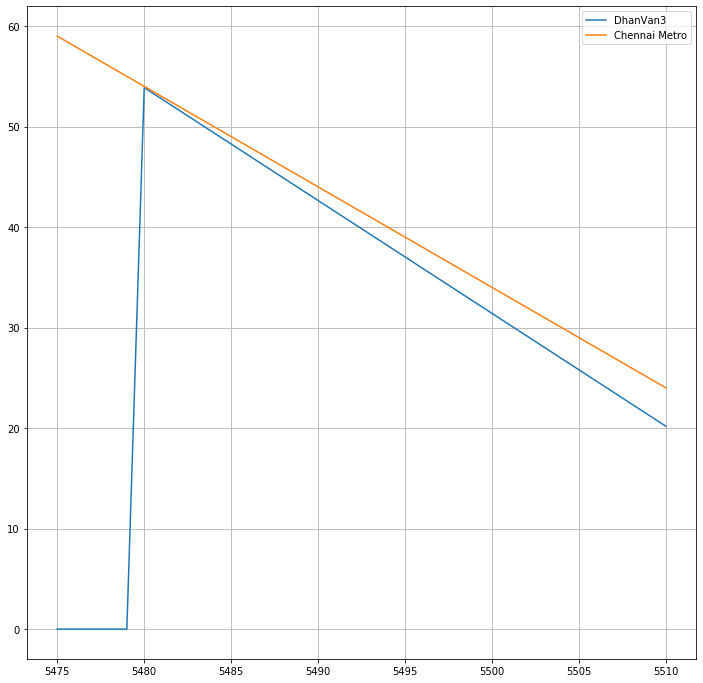

In [44]:
    
    
    start=365*15
    end=start+36
    if(start+36>len(raw)):
        end=len(raw)
    plt.figure(figsize=(12,12))
    plt.plot(range(start,end),b[start:end])
    #plt.plot(range(start,end),a[start:end],linestyle='dashed')
    plt.plot(range(start,end),raw.iloc[start:end,0])
    #plt.plot(range(start,end),c[start:end])
    plt.legend(['DhanVan3','Chennai Metro','ELanGO'])
    plt.grid()
    plt.show()

In [73]:
env3=Chembarambaakam()
from keras.layers import LSTM,Dense,Input,Add,Flatten
from keras import optimizers
from keras.models import Model
state_input = Input(shape=env3.observation_space.shape)
lstm = Dense(32,activation='relu')(state_input)
outd= Dense(1)(lstm)
out=Flatten()(outd)
hidden2=Dense(16,activation='relu')(out)

state_input2 = Input(shape=env3.observation_space.shape)
hiddenn1=Flatten()(state_input2)
hidden1=Dense(16,activation='relu')(hiddenn1)

elango2=Model(input=state_input,output=out)
elango2.name='Elango2'


elango2.compile(loss='mae', optimizer=optimizers.RMSprop())





merged    = Add()([hidden1, hidden2])
merged_h1 = Dense(8, activation='relu')(merged)
output = Dense(1, activation='relu')(merged_h1)
eshwari2  = Model(input=[state_input,state_input2], 
            output=output)

eshwari2.compile(loss='mae', optimizer=optimizers.RMSprop())
eshwari2.name='Eshwari2'

C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  from ipykernel import kernelapp as app
C:\Users\R. Senthil Kumar\anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [74]:
eshwari2.summary()

Model: "Eshwari2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 5, 4)         0                                            
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 5, 32)        160         input_23[0][0]                   
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 5, 4)         0                                            
__________________________________________________________________________________________________
dense_58 (Dense)                (None, 5, 1)         33          dense_57[0][0]                   
___________________________________________________________________________________________

In [76]:
env=Chembarambaakam()

num_episodes=1
print('processing....')
for ds in range(0,num_episodes):
        if(ds%100)==0:
            print('\nEpsisode: ',ds,end='')
        else:
            print('->',end='')
        state = env.reset()
        #state = np.reshape(state, [1, observation_space])
        epsilon=0.95
        decay=0.99
        gamma=0.95
        done=False
        while not done:
            #print('o')
            if(decay>0 and np.random.random()<epsilon/decay):
                action=np.random.random()*env.action_space.high[0]
                decay*=decay
            else:
                action = elango2.predict(np.array([state]))[0][0]
                
            state_next, reward, done, _ = env.step(action)
            if(done):
                break
            action2 = elango2.predict(np.array([state_next]))[0][0]
            env2=env
            _,reward2, _, _=env2.step(action2)
            q_value= reward + gamma *reward2      
            eshwari2.fit([np.array([state]),np.array([state])],np.array([q_value]),epochs=1,verbose=0,batch_size=1)
            state=state_next
        
            

processing....

Epsisode:  0

In [71]:
env=Chembarambaakam()
state=env.reset()
elango2.predict(np.array([state]))[0][0]

-0.069524944

In [54]:

elango.predict(np.array([state]))[0][0]

-0.0531623

In [55]:

DhanVan3.predict(np.array([state]))[0][0]

-0.54709053